In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import quantum_imaging as qi
import quantum_drawer as qd
from IPython.display import Image
import numpy as np
%matplotlib inline

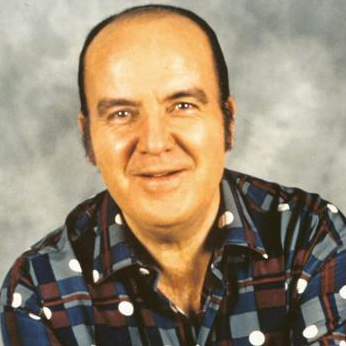

In [2]:
Image('quantum-fistro.png')

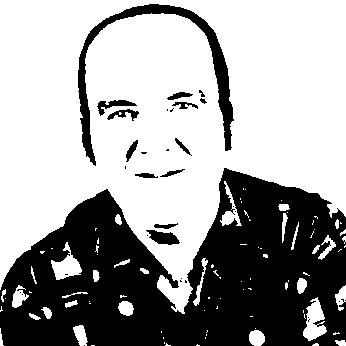

In [3]:
image_fistro = qi.convert_to_bw("quantum-fistro.png")
qi.image_from_array(image_fistro)

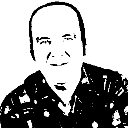

In [4]:
resized_image_fistro = qi.resize_array(image_fistro, size=(128, 128))
qi.image_from_array(resized_image_fistro)

In [5]:
array_binary_fistro = qi.binary_encode(resized_image_fistro)
qi.save_bin_array_to_csv('quantum_fistro_singular.csv', array_binary_fistro)

# Use one-hot encoding drawing file to create a Quantum circuit and rebuild the image with the circuit result

# Using the Aer simulator

In [6]:
# Simulator
qasm_sim = Aer.get_backend("aer_simulator")

# Number of circuit qubits
n_qubits = 7

In [33]:
binary_data_array = qi.load_bin_array_from_csv('quantum_fistro_singular.csv')

cols_items = binary_data_array.shape[1]
splitting = qd.splitting_chunks(cols_items, n_qubits)

rework_image_sim = qd.rebuild_image_quantum_enhance_onerun(binary_data_array, splitting, n_qubits, qasm_sim)
rework_image_sim.shape

Sending 1 job(s) to Quantum Simulator...


(128, 128)

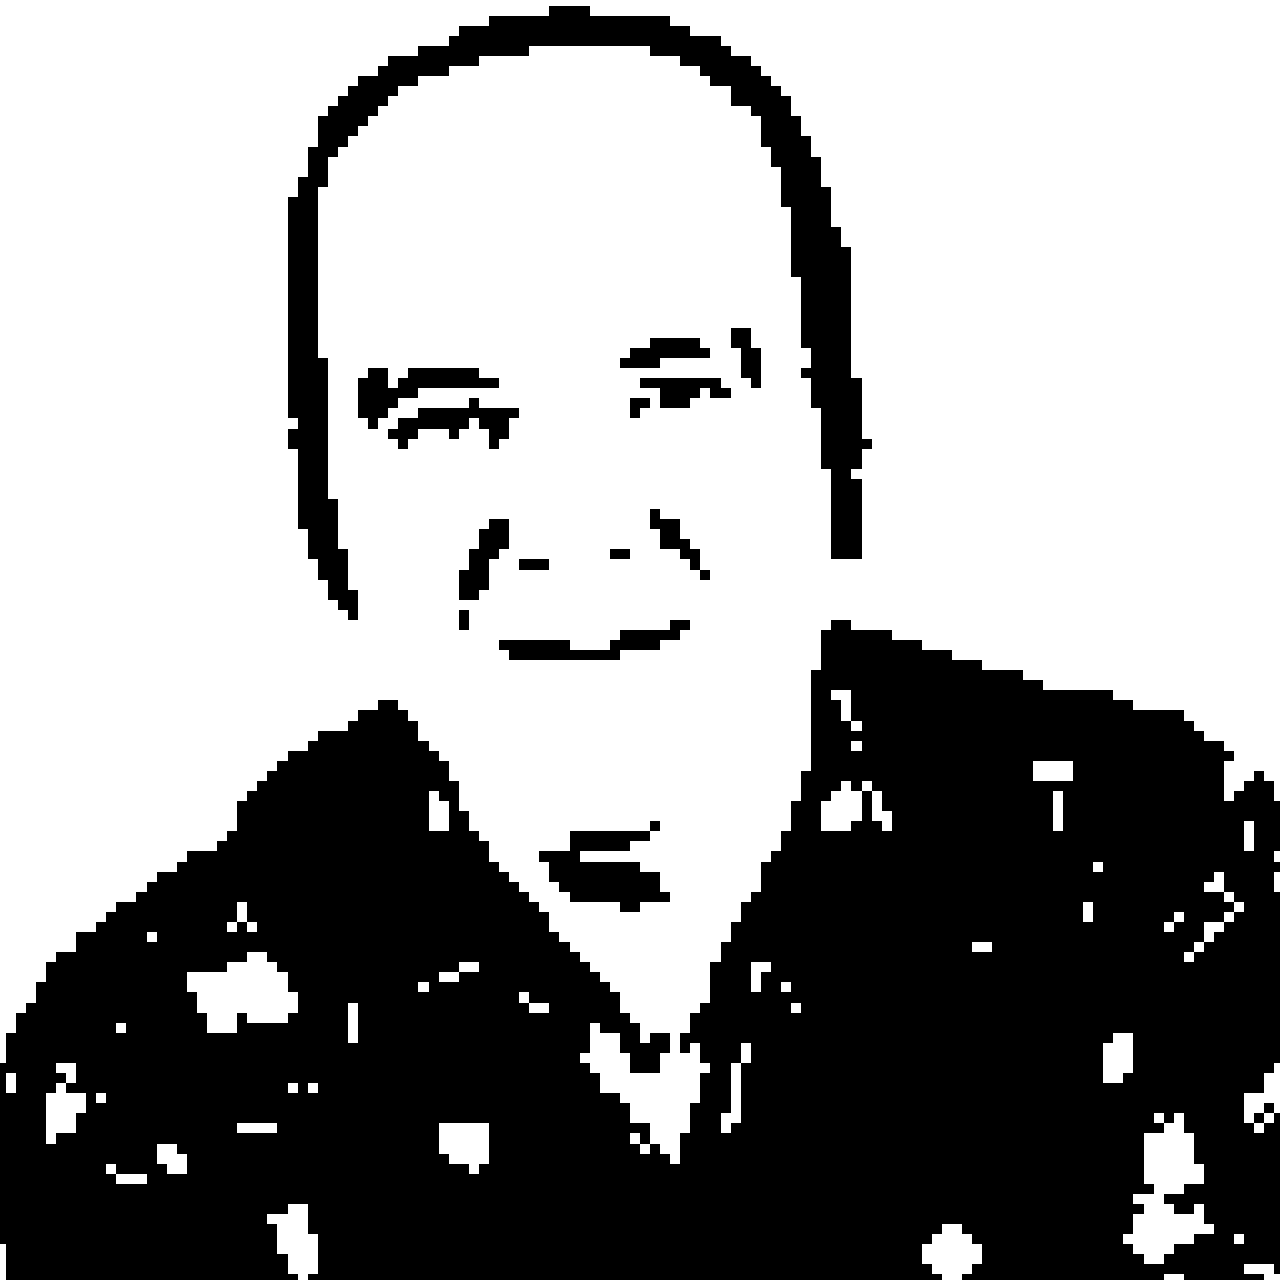

In [36]:
rebuild_data_sim = qi.rebuild_binary_array(rework_image_sim)
#inverted_rebuild_data = qi.invert_data(rebuild_data_sim)
#qi.image_from_array(rebuild_data_sim)
scaled_image = qi.scale_binary_image(rebuild_data_sim, 10)
image_final_sim = qi.image_from_array(scaled_image)
image_final_sim

In [37]:
qi.save_image_to_jpg(image_final_sim, 'fistro-sim2.png')

# Now, send the circuit to real Quantum Computer

In [9]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
import qiskit.tools.jupyter

In [ ]:
if not IBMQ.active_account():
    IBMQ.load_account()

all_providers = IBMQ.providers()

provider = all_providers[0] #IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider

In [11]:
%qiskit_backend_overview

In [12]:
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= n_qubits and b.status().operational and not b.configuration().simulator))

In [ ]:
backend

In [14]:
binary_data_array = qi.load_bin_array_from_csv('quantum_fistro_singular.csv')

cols_items = binary_data_array.shape[1]
splitting = qd.splitting_chunks(cols_items, n_qubits)

In [15]:
# Estimated jobs to send to the real Quantum Computer

rows = binary_data_array.shape[0]
columns = binary_data_array.shape[1]
max_experiments_backend = backend.configuration().max_experiments

num_jobs = qd.estimate_sent_jobs(rows, columns, n_qubits, max_experiments_backend)

print("The system will send {:0d} job(s) to the REAL Quantum Computer".format(num_jobs))

The system will send 9 job(s) to the REAL Quantum Computer


In [16]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [17]:
rework_image = qd.rebuild_image_quantum_enhance_onerun(binary_data_array, splitting, n_qubits, backend, num_shots = 1024)
rework_image.shape

Sending 9 job(s) to Quantum Computer...
job ID:  61b5113673fb2492f6d1c859
job ID:  61b514df8a02212568296122
job ID:  61b5182de4d3eb1c945c94da
job ID:  61b51c2f72d4b533f6a72102
job ID:  61b51f805d7c532b5db0a506
job ID:  61b52315a43b0c1ab42afbb7
job ID:  61b5264473fb2486cbd1c8a6
job ID:  61b52bbae4d3eb1b1a5c9511
job ID:  61b52da15d7c53e783b0a52b


(128, 128)

In [18]:
%qiskit_disable_job_watcher

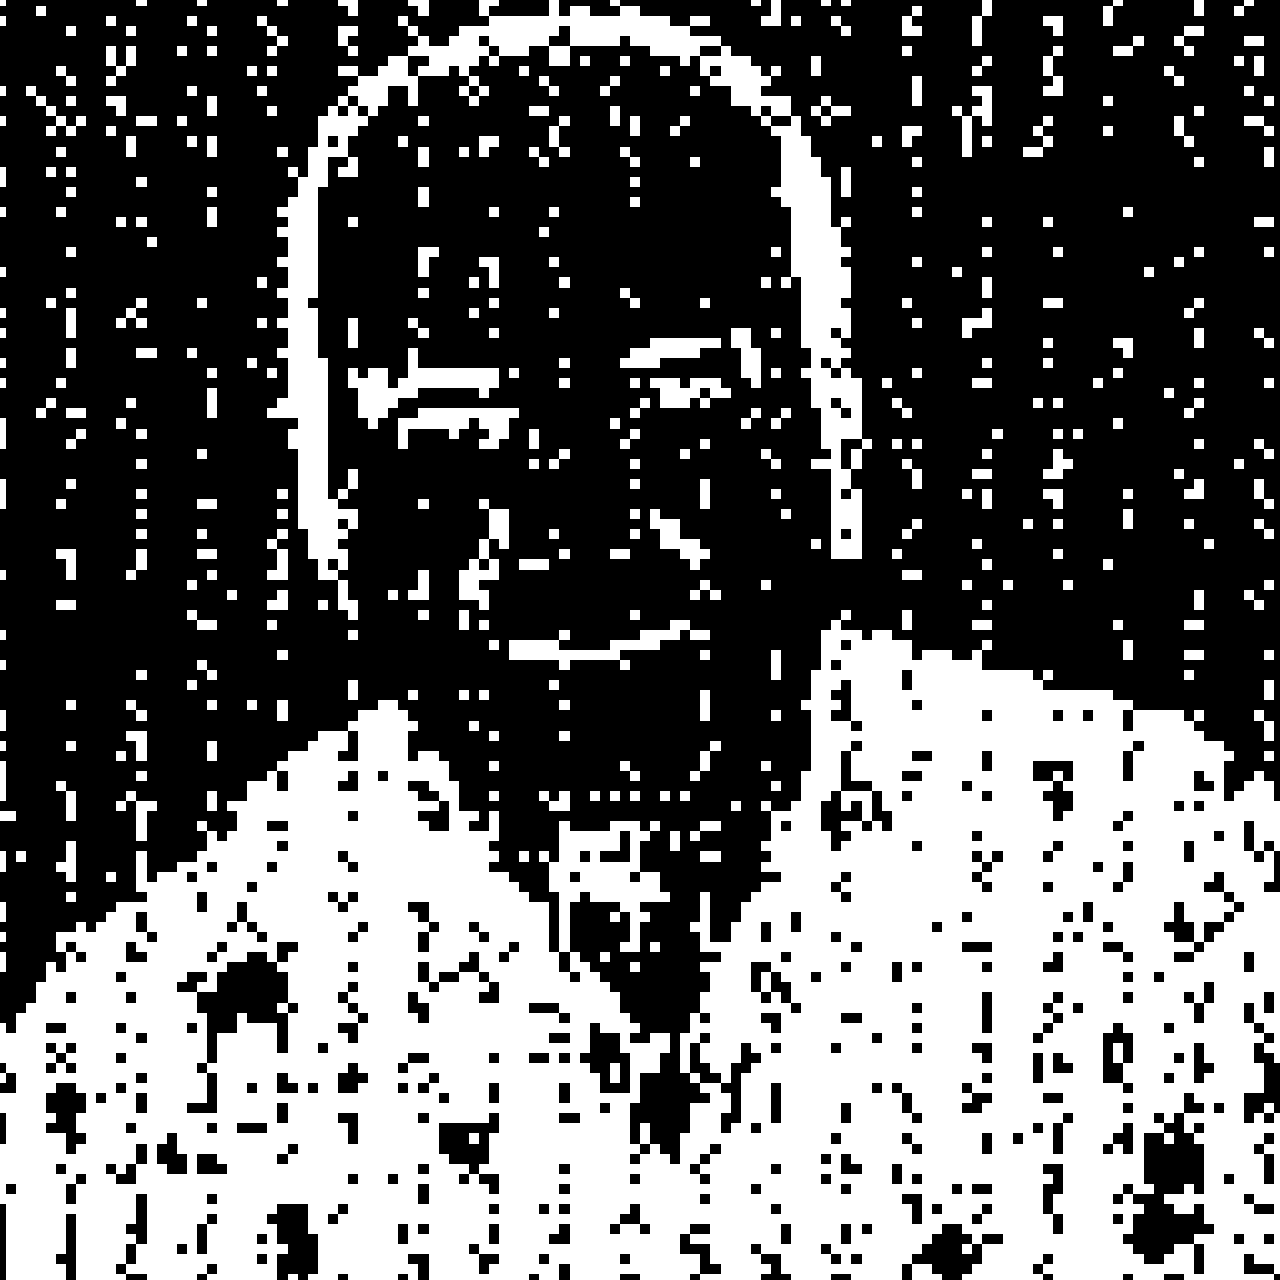

In [40]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image_qc = qi.scale_binary_image(rebuild_data, 10)
qi.image_from_array(scaled_image_qc)

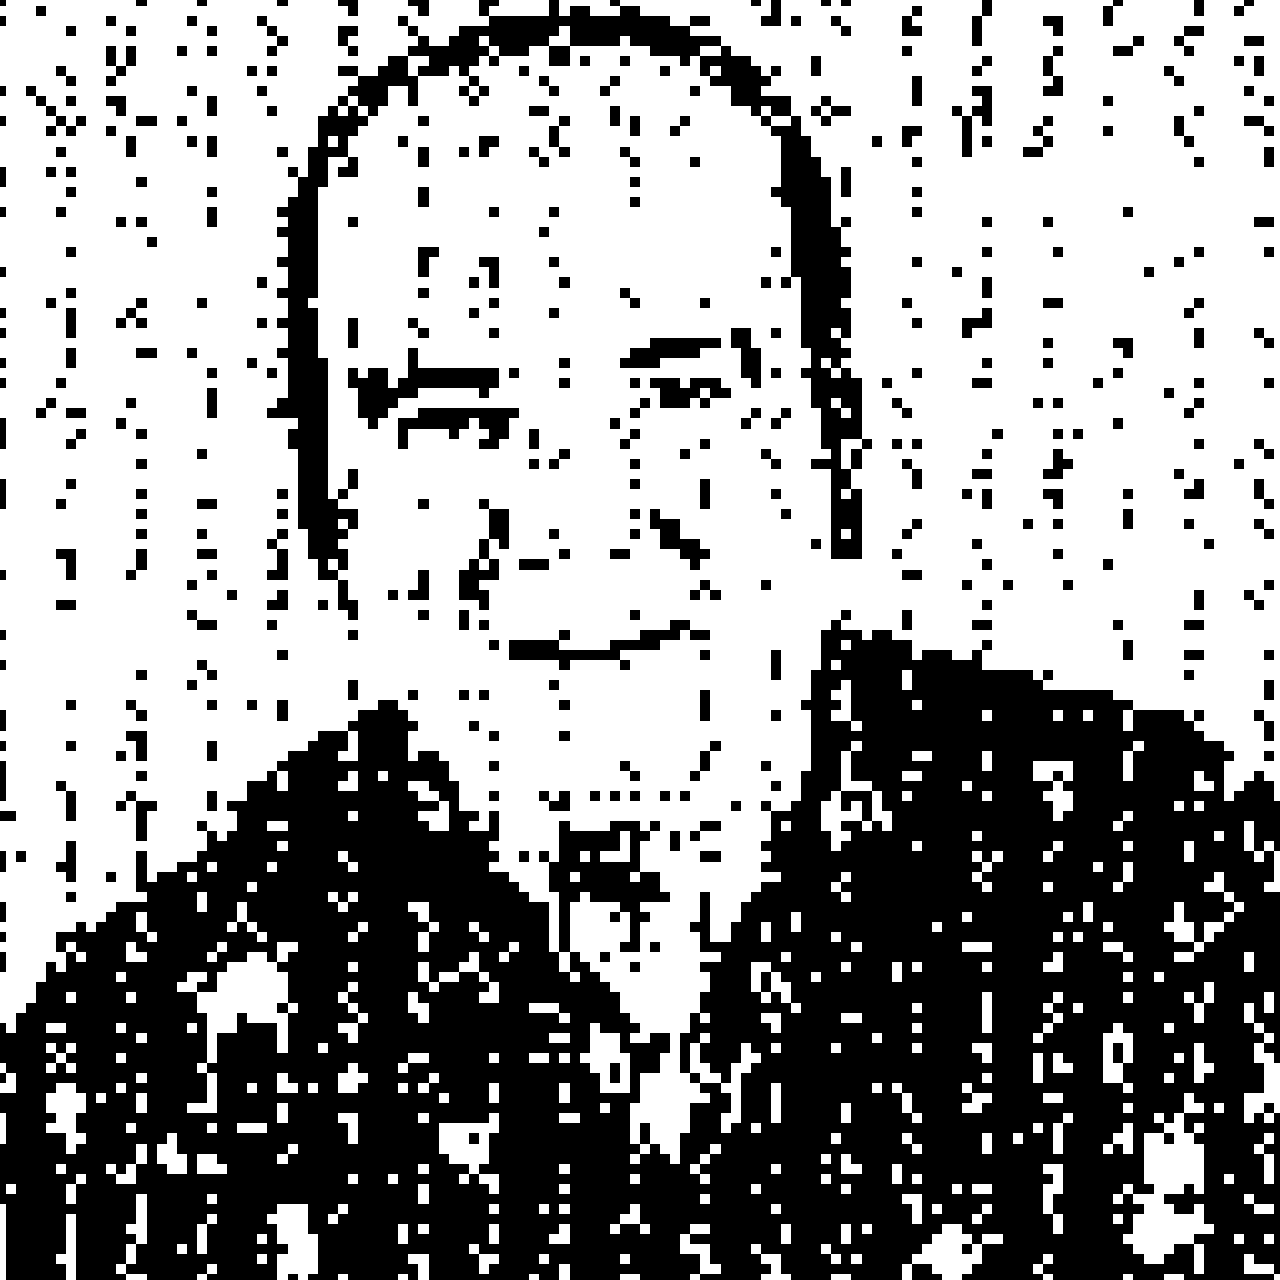

In [45]:
inverted_qc = qi.invert_data(scaled_image_qc)
image_final_qc = qi.image_from_array(inverted_qc)
image_final_qc

In [47]:
array_binary_ibmq = qi.binary_encode(scaled_image_qc)
qi.save_bin_array_to_csv('quantum_fistro_singular_ibmq.csv', array_binary_ibmq)

In [46]:
qi.save_image_to_jpg(image_final_qc, 'fistro-qc2.png')

# Recover image from job ids

In [48]:
backend = provider.get_backend('ibmq_jakarta')

In [49]:
array_jobs = ["61b5113673fb2492f6d1c859",
              "61b514df8a02212568296122", 
              "61b5182de4d3eb1c945c94da", 
              "61b51c2f72d4b533f6a72102", 
              "61b51f805d7c532b5db0a506", 
              "61b52315a43b0c1ab42afbb7", 
              "61b5264473fb2486cbd1c8a6", 
              "61b52bbae4d3eb1b1a5c9511",
              "61b52da15d7c53e783b0a52b"]

In [50]:
n_qubits = 7
cols_items = binary_data_array.shape[1]
splitting = qd.splitting_chunks(cols_items, n_qubits)

rebuild_data_jobs = qd.recover_image_jobs(array_jobs, backend, splitting, cols_items)
rebuild_data_jobs

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 1, 1, 0]], dtype=uint8)

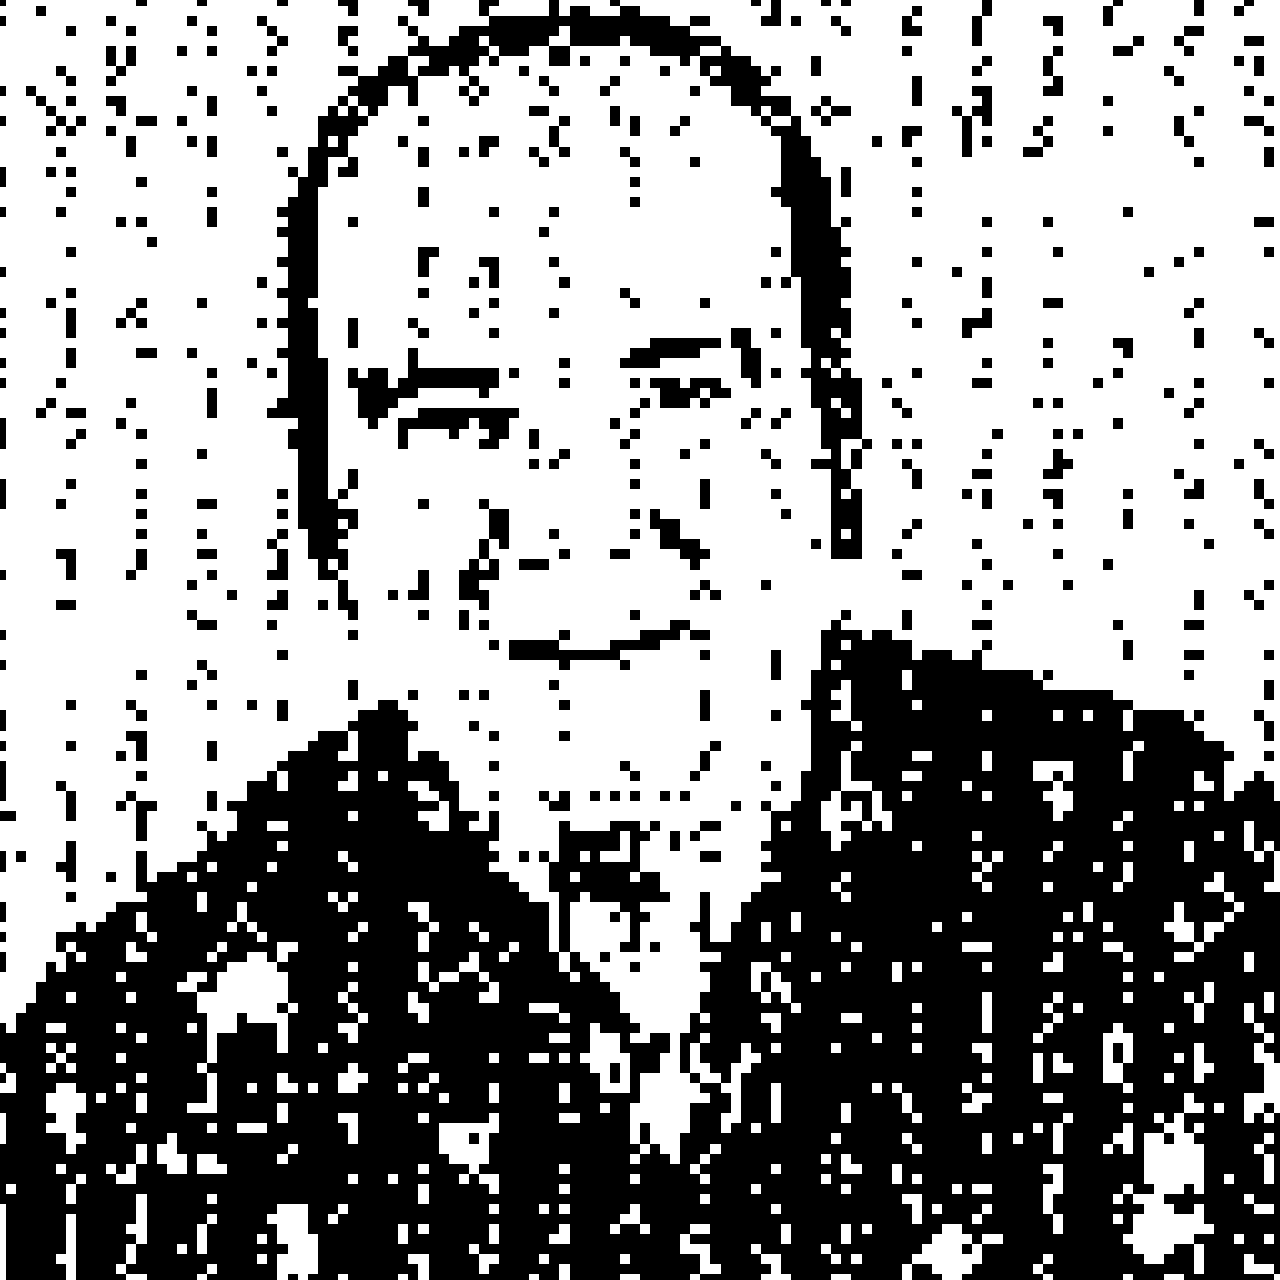

In [51]:
rebuild_data_loaded_raw = qi.rebuild_binary_array(rebuild_data_jobs)
scaled_image_jobs = qi.scale_binary_image(rebuild_data_loaded_raw, 10)
inverted_final_jobs = qi.invert_data(scaled_image_jobs)
qi.image_from_array(inverted_final_jobs)

In [ ]:
%qiskit_version_table